In [1]:
import torch
import torchvision.transforms as transforms 
import torch.nn.init
from torchsummary import summary as summary_
import json
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils import data
import torchvision.datasets as datasets

In [2]:
#Train data 받아오기
class_num = list(0. for i in range(5))

path_dir = 'aug_json' #Parse 폴더에서 파일명 불러오기
file_list_train = os.listdir(path_dir)

In [3]:
TRAIN_SIZE = len(file_list_train)
label = [0 for i in range(TRAIN_SIZE)] #list형
path_dir_img = 'aug_all'

def make_file_list():
    #train_img_list = [0 for i in range(len(file_list_train))]
    train_img_list = [0 for i in range(TRAIN_SIZE)]
    cnt = 0
    #for i in file_list_train:
    for i in range(TRAIN_SIZE):
    
        with open(path_dir +'/'+ file_list_train[cnt], "r") as st_json:
            load_data = json.load(st_json)

        category = load_data.get('category_id') #class 찾아오기
        class_num[category]+=1
        #print(category)
        str = file_list_train[cnt].split('.')[0]
        train_img_list[cnt] = path_dir_img +'/'+ str+".jpg" #이미지파일 파일명 생성
        label[cnt] = category

        cnt+=1

    return train_img_list


In [4]:
class ImageTransform():

    def __init__(self):
        
        self.data_transform = transforms.Compose([
            #transforms.CenterCrop(720),
            #transforms.Resize(256),
            #transforms.Normalize([train_meanR, train_meanG, train_meanB], [train_stdR, train_stdG, train_stdB]),
            transforms.ToTensor(),
        ])
        

    def __call__(self, img):
        return self.data_transform(img)

In [5]:
class Img_Dataset(data.Dataset):

    def __init__(self, file_list, transform):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, index):
        img_path = self.file_list[index]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        img_label = label[index]

        return img_transformed,img_label

In [6]:
train_img_list=make_file_list()

In [7]:
for i in range(5):
    print(class_num[i])

840.0
19936.0
80872.0
29216.0
1816.0


In [8]:
train_dataset = Img_Dataset(file_list=train_img_list,
                            transform=ImageTransform())

In [9]:
train_dataloader = data.DataLoader(train_dataset,
                                   batch_size=128,
                                   shuffle=True,
                                   drop_last=True)
print('Dataloader created')

Dataloader created


In [10]:
path_dir = 'LJH/data/product_data/val/Item-Parse_f'
path_dir_img = 'valid'
file_list_val = os.listdir(path_dir)
Val_size = len(file_list_val)
label_val = [0 for i in range(Val_size)] 
def make_file_list_val():
    val_img_list = [0 for i in range(Val_size)]
    cnt = 0
    #for i in file_list_test:
    for i in range(Val_size):
    
        with open(path_dir +'/'+ file_list_val[cnt], "r") as st_json:
            load_data = json.load(st_json)

        category = load_data.get('category_id') #class 찾아오기
        #print(category)
        str = file_list_val[cnt].split('.')[0]
        val_img_list[cnt] = path_dir_img +'/'+ str+".jpg" #이미지파일 파일명 생성
        label_val[cnt] = category

        cnt+=1

    return val_img_list

In [11]:
class Img_Dataset(data.Dataset):

    def __init__(self, file_list, transform):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, index):
        img_path = self.file_list[index]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        img_label = label_val[index]

        return img_transformed,img_label

In [12]:
val_img_list=make_file_list_val()

In [13]:
val_dataset = Img_Dataset(file_list=val_img_list, transform=ImageTransform())

In [14]:
val_dataloader = data.DataLoader(val_dataset,
                                   batch_size=128,
                                   shuffle=False,
                                   drop_last=True)

In [15]:
batch_iterator = iter(train_dataloader)
images = next(batch_iterator)

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [17]:
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
            nn.Conv2d(out_channels, out_channels * BasicBlock.expansion, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels * BasicBlock.expansion),
        )

        self.shortcut = nn.Sequential()
        self.relu = nn.LeakyReLU(0.2)
        
        if stride != 1 or in_channels != BasicBlock.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BasicBlock.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * BasicBlock.expansion)
            )

    def forward(self, x):
        x = self.residual_function(x) + self.shortcut(x)
        x = self.relu(x)
        return x


class BottleNeck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
            nn.Conv2d(out_channels, out_channels * BottleNeck.expansion, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels * BottleNeck.expansion),
        )

        self.shortcut = nn.Sequential()

        self.relu = nn.ReLU()

        if stride != 1 or in_channels != out_channels * BottleNeck.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels*BottleNeck.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels*BottleNeck.expansion)
            )
            
    def forward(self, x):
        x = self.residual_function(x) + self.shortcut(x)
        x = self.relu(x)
        return x

In [18]:
class ResNet(nn.Module):
    def __init__(self, block, num_block, num_classes=5, init_weights=True):
        super().__init__()

        self.in_channels=64

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.conv2_x = self._make_layer(block, 64, num_block[0], 1)
        self.conv3_x = self._make_layer(block, 128, num_block[1], 2)
        self.conv4_x = self._make_layer(block, 256, num_block[2], 2)
        self.conv5_x = self._make_layer(block, 512, num_block[3], 2)

        self.avg_pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        # weights inittialization
        if init_weights:
            self._initialize_weights()

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion

        return nn.Sequential(*layers)

    def forward(self,x):
        output = self.conv1(x)
        output = self.conv2_x(output)
        x = self.conv3_x(output)
        x = self.conv4_x(x)
        x = self.conv5_x(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    # define weight initialization function
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

def resnet18():
    return ResNet(BasicBlock, [2,2,2,2])

def resnet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])

def resnet50():
    return ResNet(BottleNeck, [3,4,6,3])

def resnet101():
    return ResNet(BottleNeck, [3, 4, 23, 3])

def resnet152():
    return ResNet(BottleNeck, [3, 8, 36, 3])

In [19]:
from torchsummary import summary as summary_
DEVICE_IDS = [0,1]
model = resnet50().to(device)
summary_(model,(3,256,256),batch_size = 128)
resnet50 = torch.nn.parallel.DataParallel(resnet50, device_ids=DEVICE_IDS)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [128, 64, 128, 128]           9,408
       BatchNorm2d-2        [128, 64, 128, 128]             128
              ReLU-3        [128, 64, 128, 128]               0
         MaxPool2d-4          [128, 64, 64, 64]               0
            Conv2d-5          [128, 64, 64, 64]           4,096
       BatchNorm2d-6          [128, 64, 64, 64]             128
         LeakyReLU-7          [128, 64, 64, 64]               0
            Conv2d-8          [128, 64, 64, 64]          36,864
       BatchNorm2d-9          [128, 64, 64, 64]             128
        LeakyReLU-10          [128, 64, 64, 64]               0
           Conv2d-11         [128, 256, 64, 64]          16,384
      BatchNorm2d-12         [128, 256, 64, 64]             512
           Conv2d-13         [128, 256, 64, 64]          16,384
      BatchNorm2d-14         [128, 256,

/home/rpc/.local/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [20]:
criterion = torch.nn.CrossEntropyLoss().to(device) 
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [21]:
total_batch = len(train_dataloader)
val_total_batch = len(val_dataloader)
epochs = 10
x_values = []
train_loss = []
test_loss = []
for epoch in range(epochs): 
    avg_cost = 0 
    cnt = 0
    val_avg_cost = 0
    
    for X, Y in train_dataloader: 
        X = X.to(device) 
        Y = Y.to(device) 
        
        optimizer.zero_grad() 
        hypothesis = model(X) 
        cost = criterion(hypothesis, Y) 
        cost.backward() 
        optimizer.step() 
       
        avg_cost += cost / total_batch
        
    with torch.no_grad():
        for A, B in val_dataloader:
            A = A.to(device)
            B = B.to(device)
            val_output = model(A)
            val_loss = criterion(val_output,B)
            val_avg_cost += val_loss / val_total_batch

    x_values.append(epoch+1)
    train_loss.append(avg_cost)
    test_loss.append(val_avg_cost)
 
    print('[Epoch: {:>4}] loss = {:>.9}   test_loss = {:>.9}'.format(epoch + 1, avg_cost, val_avg_cost))

[Epoch:    1] loss = 0.329588622   test_loss = 0.184062779
[Epoch:    2] loss = 0.136371985   test_loss = 0.130005136
[Epoch:    3] loss = 0.0651361197   test_loss = 0.120073713
[Epoch:    4] loss = 0.0386640579   test_loss = 0.130288512
[Epoch:    5] loss = 0.0289993696   test_loss = 0.149142683
[Epoch:    6] loss = 0.0250780545   test_loss = 0.134022892
[Epoch:    7] loss = 0.024518257   test_loss = 0.120396048
[Epoch:    8] loss = 0.0180869307   test_loss = 0.13972801
[Epoch:    9] loss = 0.017375106   test_loss = 0.155341551
[Epoch:   10] loss = 0.0137238344   test_loss = 0.120661229


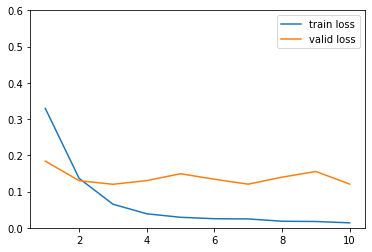

In [33]:
plt.plot(x_values, train_loss)
plt.plot(x_values, test_loss)
plt.ylim([0, 0.6])
plt.legend(['train loss', 'valid loss'])
plt.show()

In [34]:
path_dir = 'LJH/data/product_data/test/Item-Parse_f'
path_dir_img = 'test'
file_list_test = os.listdir(path_dir)
Test_size = len(file_list_test)
#label_test = [0 for i in range(len(file_list_test))] #list형
label_test = [0 for i in range(Test_size)] 
def make_file_list_test():
    #test_img_list = [0 for i in range(len(file_list_test))]
    test_img_list = [0 for i in range(Test_size)]
    cnt = 0
    #for i in file_list_test:
    for i in range(Test_size):
    
        with open(path_dir +'/'+ file_list_test[cnt], "r") as st_json:
            load_data = json.load(st_json)

        category = load_data.get('category_id') #class 찾아오기
        #print(category)
        str = file_list_test[cnt].split('.')[0]
        test_img_list[cnt] = path_dir_img +'/'+ str+".jpg" #이미지파일 파일명 생성
        label_test[cnt] = category

        cnt+=1

    return test_img_list

In [24]:
class Img_Dataset(data.Dataset):

    def __init__(self, file_list, transform):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, index):
        img_path = self.file_list[index]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        img_label = label_test[index]

        return img_transformed,img_label

In [25]:
test_img_list=make_file_list_test()

In [26]:
test_dataset = Img_Dataset(file_list=test_img_list, transform=ImageTransform())

In [27]:
test_dataloader = data.DataLoader(test_dataset,
                                   batch_size=32,
                                   shuffle=False,
                                   drop_last=True)

In [28]:
#Testing classification accuracy for individual classes.
correct = 0
total = 0
class_correct = list(0. for i in range(5))
class_total = list(0. for i in range(5))
arr = [[0]*5 for i in range(5)]
with torch.no_grad():
    for datas in test_dataloader:
        images, labels = datas[0].to(device), datas[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(32):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
            arr[label][predicted[i]] += 1
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        

for i in range(5):
    print('Accuracy of %d : %2d %%' % (
        i, 100 * class_correct[i] / class_total[i]))
print('total Accurarcy : %2d %%' %(100 * correct / total))
print()
print('Num  of total : %2d / %2d  ' %(correct, total))
for i in range(5):
    print('Num of %d : %2d / %2d' % (
        i, class_correct[i], class_total[i]))

Accuracy of 0 : 100 %
Accuracy of 1 : 89 %
Accuracy of 2 : 97 %
Accuracy of 3 : 98 %
Accuracy of 4 : 97 %
total Accurarcy : 97 %

Num  of total : 7674 / 7904  
Num of 0 : 24 / 24
Num of 1 : 793 / 889
Num of 2 : 4092 / 4176
Num of 3 : 2687 / 2735
Num of 4 : 78 / 80


In [29]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn

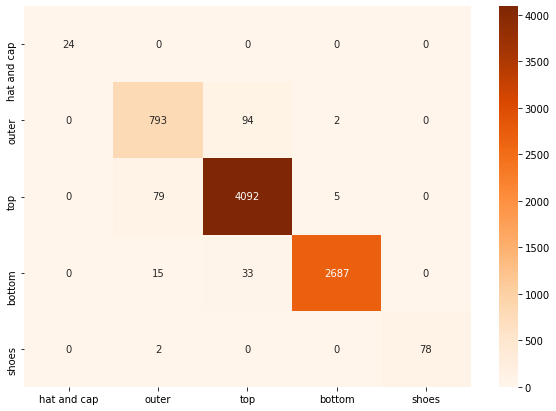

In [30]:
#confusion Metrix
classes = ["hat and cap", "outer", "top", "bottom","shoes"]
df_cfm = pd.DataFrame(arr, index = classes, columns = classes)
plt.figure(figsize = (10,7))
cfm_plot = sn.heatmap(df_cfm, annot=True,  cmap='Oranges', fmt='g')

In [31]:
print(len(val_img_list))

7978
